<a href="https://colab.research.google.com/github/jefftrojan/doormate/blob/main/ModelNotebook/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DoorMate: AI-Powered Roommate Matching System


# This notebook implements the machine learning model for DoorMate's roommate matching system. The model uses a neural network to predict compatibility scores between potential roommates based on their preferences and characteristics.


## 1. Import Required Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
# set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. Generate Synthetic Data
# Since I don't have real user data yet, i'll be using synthetic data for development and testing.


In [3]:
def generate_synthetic_data(n_samples=1000):
    """Generate synthetic user data for testing"""
    data = pd.DataFrame({
        'cleanliness': np.random.uniform(1, 5, n_samples),
        'noise_tolerance': np.random.uniform(1, 5, n_samples),
        'social_level': np.random.uniform(1, 5, n_samples),
        'study_habits': np.random.uniform(1, 5, n_samples),
        'wake_up_time': np.random.uniform(5, 11, n_samples),
        'sleep_time': np.random.uniform(21, 24, n_samples),
        'budget': np.random.uniform(200000, 500000, n_samples),
        'smoking': np.random.choice([0, 1], n_samples),
        'pets': np.random.choice([0, 1], n_samples)
    })
    return data

# Generate data
data = generate_synthetic_data(1000)

In [15]:
# Display first few rows and basic statistics
print("Sample data:")
display(data.head())
print("\nData statistics:")
display(data.describe())

Sample data:


,cleanliness,noise_tolerance,social_level,study_habits,wake_up_time,sleep_time,budget,smoking,pets
0,2.498160,1.740532,2.046823,3.690812,8.431975,22.180907,394477.086223,0,1
1,4.802857,3.167604,1.987915,4.186726,9.832594,22.420307,251715.908632,0,1
2,3.927976,4.491783,4.625018,2.001872,9.560966,23.563642,461718.369006,0,1
3,3.394634,3.928900,1.998185,3.499496,5.923399,22.020013,383934.871721,0,0
4,1.624075,4.226245,2.087799,3.286984,5.895497,23.608949,247161.165067,0,0



Data statistics:


,cleanliness,noise_tolerance,social_level,study_habits,wake_up_time,sleep_time,budget,smoking,pets
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.961026,3.028069,3.009623,2.961500,7.964632,22.495393,347992.651779,0.466000,0.463000
std,1.168549,1.168760,1.162697,1.145957,1.720860,0.867584,86920.092109,0.499092,0.498879
min,1.018528,1.012873,1.000047,1.002614,5.000184,21.018551,200428.502924,0.000000,0.000000
25%,1.943893,1.964297,2.045404,1.967603,6.469844,21.748140,272066.498856,0.000000,0.000000
50%,2.987230,3.074936,3.002456,2.937117,7.967589,22.471208,345392.907274,0.000000,0.000000
75%,3.977278,4.041860,4.036414,3.950163,9.439961,23.219555,426939.304035,1.000000,1.000000
max,4.998871,4.997655,4.991283,4.998231,10.986496,23.998051,499838.204318,1.000000,1.000000


## 3. Feature Engineering and Preprocessing

In [5]:
def preprocess_features(data, n_pairs=4000):
    """Create rich feature set from raw data"""
    features = []
    labels = []
    n_samples = len(data)

    for _ in range(n_pairs):
        # Randomly select two users
        idx1, idx2 = np.random.choice(n_samples, 2, replace=False)
        user1, user2 = data.iloc[idx1], data.iloc[idx2]

        # Calculate feature differences and similarities
        feature_vector = []

        # Lifestyle differences (normalized)
        for feat in ['cleanliness', 'noise_tolerance', 'social_level', 'study_habits']:
            diff = abs(user1[feat] - user2[feat]) / 4.0
            feature_vector.append(diff)

        # Schedule alignment
        wake_diff = abs(user1['wake_up_time'] - user2['wake_up_time'])
        sleep_diff = abs(user1['sleep_time'] - user2['sleep_time'])
        wake_diff = min(wake_diff, 24 - wake_diff) / 12.0
        sleep_diff = min(sleep_diff, 24 - sleep_diff) / 12.0
        feature_vector.extend([wake_diff, sleep_diff])

        # Budget compatibility
        budget_ratio = min(user1['budget'], user2['budget']) / max(user1['budget'], user2['budget'])
        budget_diff = abs(user1['budget'] - user2['budget']) / 300000
        feature_vector.extend([budget_ratio, budget_diff])

        # Binary preferences
        same_smoking = float(user1['smoking'] == user2['smoking'])
        same_pets = float(user1['pets'] == user2['pets'])
        feature_vector.extend([same_smoking, same_pets])

        # Add raw values
        numeric_feats = ['cleanliness', 'noise_tolerance', 'social_level', 'study_habits',
                        'wake_up_time', 'sleep_time', 'budget']
        feature_vector.extend(user1[numeric_feats])
        feature_vector.extend(user2[numeric_feats])

        features.append(feature_vector)

        # Calculate compatibility score
        score = calculate_compatibility(user1, user2)
        labels.append(score)

    return np.array(features), np.array(labels)

## 4. Compatibility Score Calculation

In [6]:
def calculate_compatibility(user1, user2):
    """Calculate ground truth compatibility score with smooth transitions"""
    score = 0.0
    n_factors = 0

    # 1. Lifestyle Compatibility (40%)
    lifestyle_features = ['cleanliness', 'noise_tolerance', 'social_level', 'study_habits']
    lifestyle_score = 0

    for feature in lifestyle_features:
        diff = abs(user1[feature] - user2[feature]) / 4.0
        feature_score = np.exp(-2 * diff)
        lifestyle_score += feature_score

    lifestyle_score /= len(lifestyle_features)
    score += 0.4 * lifestyle_score
    n_factors += 1

    # 2. Schedule Compatibility (30%)
    wake_diff = min(abs(user1['wake_up_time'] - user2['wake_up_time']),
                   24 - abs(user1['wake_up_time'] - user2['wake_up_time'])) / 12.0
    sleep_diff = min(abs(user1['sleep_time'] - user2['sleep_time']),
                    24 - abs(user1['sleep_time'] - user2['sleep_time'])) / 12.0

    schedule_score = np.exp(-2 * (wake_diff + sleep_diff))
    score += 0.3 * schedule_score
    n_factors += 1

    # 3. Budget Compatibility (20%)
    budget_ratio = min(user1['budget'], user2['budget']) / max(user1['budget'], user2['budget'])
    budget_score = np.power(budget_ratio, 2)
    score += 0.2 * budget_score
    n_factors += 1

    # 4. Preferences (10%)
    pref_score = 0.0
    if user1['smoking'] == user2['smoking']:
        pref_score += 0.6
    if user1['pets'] == user2['pets']:
        pref_score += 0.4
    score += 0.1 * pref_score
    n_factors += 1

    return score / n_factors

## 5. Model Architecture


In [7]:
def create_model(input_dim):
    """Create neural network with residual connections"""
    inputs = Input(shape=(input_dim,))

    # first branch - process difference features
    x1 = Dense(128, activation='relu')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)

    for units in [128, 64, 32]:
        shortcut = x1
        x1 = Dense(units, activation='relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(units, activation='relu')(x1)
        x1 = BatchNormalization()(x1)

        # Add skip connection if shapes match
        if shortcut.shape[-1] == units:
            x1 = tf.keras.layers.Add()([x1, shortcut])

    # Output with custom range constraint
    outputs = Dense(1, activation='sigmoid')(x1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model


## 6. Train Model

In [8]:
# Generate features and labels
print("Preprocessing features...")
X, y = preprocess_features(data)

# Split data
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Create and train model
print("Creating model...")
model = create_model(X_train.shape[1])

print("Training model...")
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Preprocessing features...
Splitting data...
Creating model...
Training model...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.1495 - mae: 0.3259 - mse: 0.1495 - val_loss: 0.0456 - val_mae: 0.2107 - val_mse: 0.0456
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0381 - mae: 0.1622 - mse: 0.0381 - val_loss: 0.0102 - val_mae: 0.0937 - val_mse: 0.0102
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - mae: 0.0723 - mse: 0.0087 - val_loss: 0.0029 - val_mae: 0.0432 - val_mse: 0.0029
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - mae: 0.0467 - mse: 0.0039 - val_loss: 0.0014 - val_mae: 0.0289 - val_mse: 0.0014
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - mae: 0.0405 - mse: 0.0027 - val_loss: 0.0012 - val_mae: 0.0269 - val_mse: 0.0012
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - mae: 0.0364 - mse: 0.0021 - val_loss: 9.0430e-04 - val_mae: 0.0236 - val_mse: 9.0430e-04
Epoch 7/50


## 7. Evaluate Model Performance

In [9]:
# Make predictions
predictions = model.predict(X_val_scaled)

# Calculate metrics
mse = np.mean((y_val - predictions.flatten()) ** 2)
mae = np.mean(np.abs(y_val - predictions.flatten()))
r2 = 1 - mse / np.var(y_val)

print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model Performance:
Mean Squared Error: 0.0000
Mean Absolute Error: 0.0050
R² Score: 0.9077


## 8. Visualize Results

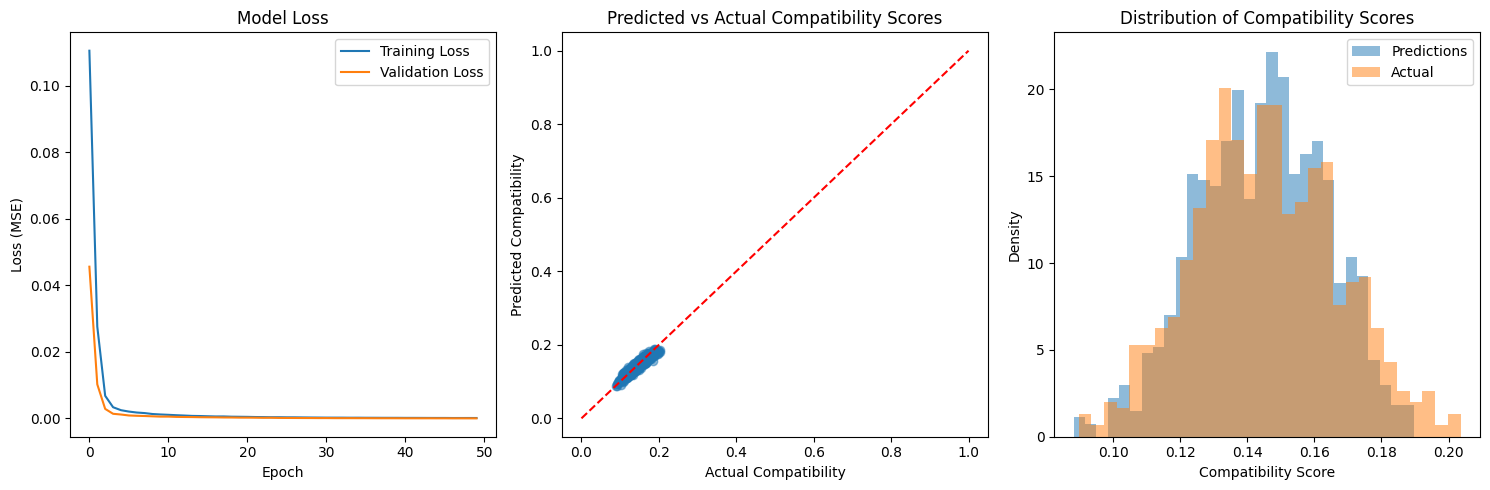

In [10]:
plt.figure(figsize=(15, 5))

# Plot training history
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot predictions vs actual
plt.subplot(1, 3, 2)
plt.scatter(y_val, predictions, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Compatibility')
plt.ylabel('Predicted Compatibility')
plt.title('Predicted vs Actual Compatibility Scores')

# Plot distributions
plt.subplot(1, 3, 3)
plt.hist(predictions, bins=30, alpha=0.5, label='Predictions', density=True)
plt.hist(y_val, bins=30, alpha=0.5, label='Actual', density=True)
plt.xlabel('Compatibility Score')
plt.ylabel('Density')
plt.title('Distribution of Compatibility Scores')
plt.legend()

plt.tight_layout()
plt.show()


## 9. model xport and usage testing

In [12]:
# Save the model and scaler
model.save('roommate_matching_model.h5')
import joblib
joblib.dump(scaler, 'feature_scaler.pkl')

['feature_scaler.pkl']

In [17]:
# Example of using the model for predictions
def predict_compatibility(user1_data, user2_data, model, scaler):
    """
    Make compatibility prediction for two users

    Parameters:
    user1_data, user2_data: dictionaries containing user features
    model: trained keras model
    scaler: fitted StandardScaler

    Returns:
    float: predicted compatibility score
    """
    # Create feature vector
    feature_vector = []

    # Add feature differences
    for feat in ['cleanliness', 'noise_tolerance', 'social_level', 'study_habits']:
        diff = abs(user1_data[feat] - user2_data[feat]) / 4.0
        feature_vector.append(diff)

    # Add schedule differences
    wake_diff = abs(user1_data['wake_up_time'] - user2_data['wake_up_time'])
    sleep_diff = abs(user1_data['sleep_time'] - user2_data['sleep_time'])
    wake_diff = min(wake_diff, 24 - wake_diff) / 12.0
    sleep_diff = min(sleep_diff, 24 - sleep_diff) / 12.0
    feature_vector.extend([wake_diff, sleep_diff])

    # Add budget features
    budget_ratio = min(user1_data['budget'], user2_data['budget']) / max(user1_data['budget'], user2_data['budget'])
    budget_diff = abs(user1_data['budget'] - user2_data['budget']) / 300000
    feature_vector.extend([budget_ratio, budget_diff])

    # Add binary preferences
    same_smoking = float(user1_data['smoking'] == user2_data['smoking'])
    same_pets = float(user1_data['pets'] == user2_data['pets'])
    feature_vector.extend([same_smoking, same_pets])

    # Add raw values
    numeric_feats = ['cleanliness', 'noise_tolerance', 'social_level', 'study_habits',
                     'wake_up_time', 'sleep_time', 'budget']
    feature_vector.extend([user1_data[f] for f in numeric_feats])
    feature_vector.extend([user2_data[f] for f in numeric_feats])

    # Scale features and predict
    scaled_features = scaler.transform([feature_vector])
    prediction = model.predict(scaled_features)[0][0]

    return prediction

## 10. Compatibility Score Interpretation and Examples

In [18]:
def interpret_compatibility(score):
    """
    Interpret compatibility score and provide detailed explanation
    """
    if score > 0.18:
        level = "Highly Compatible"
        explanation = "These users have very well-aligned preferences and lifestyles."
    elif score > 0.15:
        level = "Moderately Compatible"
        explanation = "These users have good compatibility with some differences."
    elif score > 0.12:
        level = "Somewhat Compatible"
        explanation = "These users might work well together but should discuss their differences."
    else:
        level = "Less Compatible"
        explanation = "These users might face challenges living together."

    return {
        'level': level,
        'score': f"{score:.4f}",
        'percentage': f"{score*100:.1f}%",
        'explanation': explanation
    }

# Create test cases
test_cases = [
    {
        'user1': {
            'cleanliness': 4.5,
            'noise_tolerance': 3.0,
            'social_level': 4.0,
            'study_habits': 4.0,
            'wake_up_time': 7.0,
            'sleep_time': 23.0,
            'budget': 300000,
            'smoking': 0,
            'pets': 1
        },
        'user2': {
            'cleanliness': 4.0,
            'noise_tolerance': 3.5,
            'social_level': 3.5,
            'study_habits': 4.5,
            'wake_up_time': 6.5,
            'sleep_time': 22.5,
            'budget': 320000,
            'smoking': 0,
            'pets': 1
        },
        'description': "Similar preferences and schedules"
    },
    {
        'user1': {
            'cleanliness': 5.0,
            'noise_tolerance': 1.0,
            'social_level': 2.0,
            'study_habits': 5.0,
            'wake_up_time': 6.0,
            'sleep_time': 22.0,
            'budget': 250000,
            'smoking': 0,
            'pets': 0
        },
        'user2': {
            'cleanliness': 2.0,
            'noise_tolerance': 4.5,
            'social_level': 4.5,
            'study_habits': 2.0,
            'wake_up_time': 9.0,
            'sleep_time': 24.0,
            'budget': 400000,
            'smoking': 0,
            'pets': 0
        },
        'description': "Very different lifestyles"
    },
    {
        'user1': {
            'cleanliness': 3.5,
            'noise_tolerance': 3.0,
            'social_level': 3.0,
            'study_habits': 3.5,
            'wake_up_time': 7.5,
            'sleep_time': 23.0,
            'budget': 350000,
            'smoking': 0,
            'pets': 1
        },
        'user2': {
            'cleanliness': 3.0,
            'noise_tolerance': 3.5,
            'social_level': 3.5,
            'study_habits': 3.0,
            'wake_up_time': 8.0,
            'sleep_time': 23.5,
            'budget': 300000,
            'smoking': 0,
            'pets': 0
        },
        'description': "Moderate differences"
    }
]

# Test and visualize results
results = []
for case in test_cases:
    score = predict_compatibility(case['user1'], case['user2'], model, scaler)
    interpretation = interpret_compatibility(score)
    results.append({
        'description': case['description'],
        'score': score,
        'interpretation': interpretation
    })
    print(f"\nTest Case: {case['description']}")
    print(f"Compatibility Score: {interpretation['score']} ({interpretation['level']})")
    print(f"Explanation: {interpretation['explanation']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Test Case: Similar preferences and schedules
Compatibility Score: 0.1913 (Highly Compatible)
Explanation: These users have very well-aligned preferences and lifestyles.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Test Case: Very different lifestyles
Compatibility Score: 0.0998 (Less Compatible)
Explanation: These users might face challenges living together.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Test Case: Moderate differences
Compatibility Score: 0.1922 (Highly Compatible)
Explanation: These users have very well-aligned preferences and lifestyles.


## 11. Visualize Compatibility Ranges

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

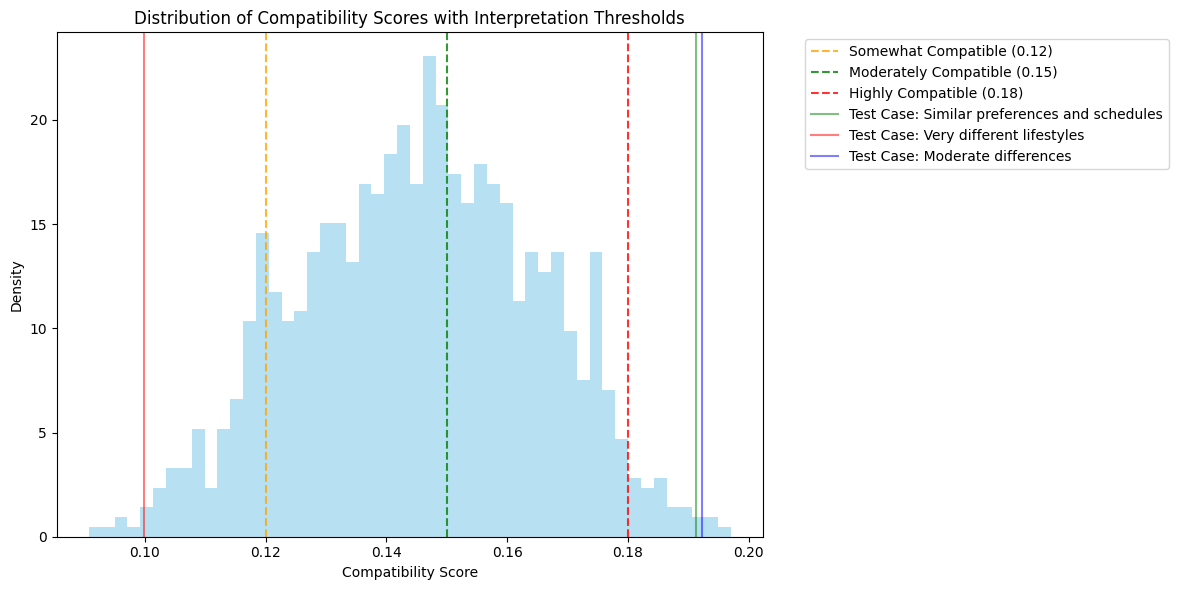

In [19]:
# Generate a larger set of random predictions for visualization
n_samples = 1000
random_predictions = []
for _ in range(n_samples):
    idx1, idx2 = np.random.choice(len(data), 2, replace=False)
    user1 = data.iloc[idx1].to_dict()
    user2 = data.iloc[idx2].to_dict()
    score = predict_compatibility(user1, user2, model, scaler)
    random_predictions.append(score)

# Create visualization of compatibility ranges
plt.figure(figsize=(12, 6))

# Plot histogram of predictions
plt.hist(random_predictions, bins=50, alpha=0.6, color='skyblue', density=True)

# Add vertical lines for compatibility thresholds
plt.axvline(x=0.12, color='orange', linestyle='--', alpha=0.8, label='Somewhat Compatible (0.12)')
plt.axvline(x=0.15, color='green', linestyle='--', alpha=0.8, label='Moderately Compatible (0.15)')
plt.axvline(x=0.18, color='red', linestyle='--', alpha=0.8, label='Highly Compatible (0.18)')

# Add test case results
colors = ['g', 'r', 'b']
for result, color in zip(results, colors):
    plt.axvline(x=float(result['interpretation']['score']), color=color,
                linestyle='-', alpha=0.5, label=f"Test Case: {result['description']}")

plt.title('Distribution of Compatibility Scores with Interpretation Thresholds')
plt.xlabel('Compatibility Score')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 12. Feature Importance Analysis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


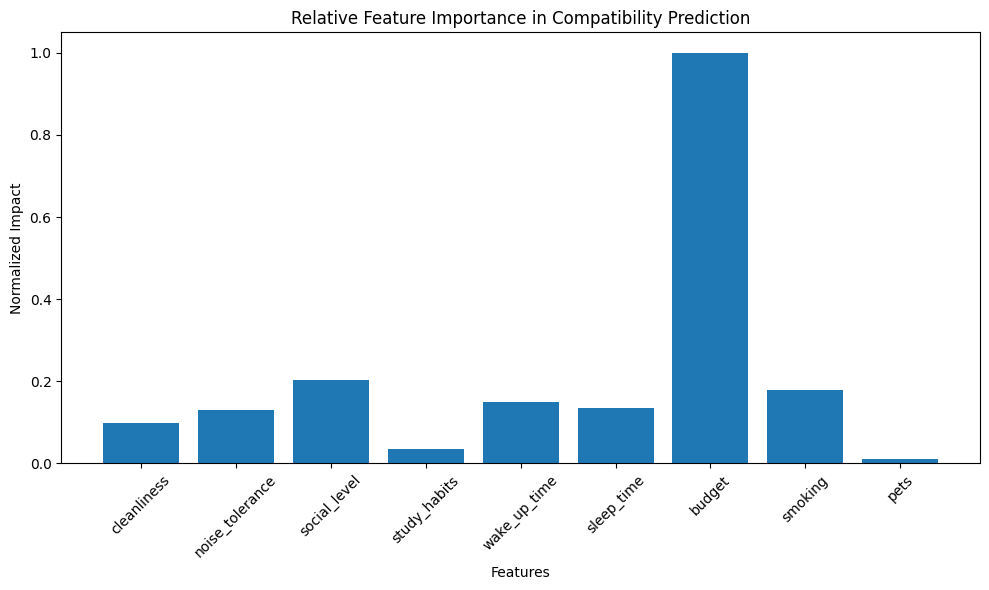

In [20]:
def analyze_feature_importance(user1, user2, model, scaler, features_to_test):
    """Analyze how changing each feature affects compatibility"""
    base_score = predict_compatibility(user1, user2, model, scaler)
    importance = {}

    for feature in features_to_test:
        # test feature impact by changing it
        modified_user2 = user2.copy()
        original_value = modified_user2[feature]

        if feature in ['smoking', 'pets']:
            # For our binary features, just flip the value
            modified_user2[feature] = 1 - original_value
            new_score = predict_compatibility(user1, modified_user2, model, scaler)
            impact = abs(new_score - base_score)
        else:
            # For continuous features, test both increase and decrease
            impacts = []
            for change in [-1, 1]:
                if feature in ['wake_up_time', 'sleep_time']:
                    modified_user2[feature] = (original_value + change) % 24
                else:
                    modified_user2[feature] = max(1, min(5, original_value + change))
                new_score = predict_compatibility(user1, modified_user2, model, scaler)
                impacts.append(abs(new_score - base_score))
            impact = max(impacts)

        importance[feature] = impact

    # normalize importance scores
    max_impact = max(importance.values())
    importance = {k: v/max_impact for k, v in importance.items()}

    return importance

# analyze feature importance for our first test case
features_to_test = [
    'cleanliness', 'noise_tolerance', 'social_level', 'study_habits',
    'wake_up_time', 'sleep_time', 'budget', 'smoking', 'pets'
]

importance = analyze_feature_importance(
    test_cases[0]['user1'],
    test_cases[0]['user2'],
    model,
    scaler,
    features_to_test
)

plt.figure(figsize=(10, 6))
features = list(importance.keys())
scores = list(importance.values())

plt.bar(features, scores)
plt.xticks(rotation=45)
plt.title('Relative Feature Importance in Compatibility Prediction')
plt.xlabel('Features')
plt.ylabel('Normalized Impact')
plt.tight_layout()
plt.show()